<a href="https://colab.research.google.com/github/MaxHenk/2022_ML_EES/blob/main/ML_PROJECT_MH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Projet pour le cours de Machine Learning for Earth & Environmental Sciences.

In [2]:
%pip install geopandas
%pip install pickle5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.0 MB/s 
     |████████████████████████████████| 7.8 MB 51.0 MB/s 
     |████████████████████████████████| 16.6 MB 56.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 132 kB 5.4 MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp38-cp38-linux_x86_64.whl size=236291 sha256=e286475d7cd2d1bdd888df15989b87b75d6daadbaaa47d72775d71d9055408c1
  Stored in directory: /root/.cache/pip/wheels/25/d4/61/dbd8edd1a0d656be7b4267c85db3b61951eb60016a0154a122
Successfully built pickle5


In [49]:
#Import Libraries
import geopandas as gpd
import pandas as pd
import numpy as np
import pickle5 as pickle
import pooch
import matplotlib.pyplot as plt     

In [4]:
#Data Loading
csv_path = 'https://unils-my.sharepoint.com/:x:/g/personal/max_henking_unil_ch/EbMKCXxTdWtKssB-sO2mOdsBksI1ABwkzsB1wagyhu8kLg?download=1'
hash='d73cc258641ea0d5b9da1bfc9ac19d947fe6e57052ef10f30fae7913730ce52b'
csv_file = pooch.retrieve(csv_path, known_hash=hash)

d1 = pd.read_csv(csv_file, index_col=0)
df = gpd.GeoDataFrame(d1, geometry=gpd.points_from_xy(d1.Geoposition_Y,d1.Geoposition_X))

In [74]:
df[['tre200h0','sre000h0','rre150h0']]

,tre200h0,sre000h0,rre150h0
19,14.2,0,0.0
29,11.5,0,0.0
54,10.4,0,0.1
78,13.0,0,1.2
103,13.9,0,0.1
...,...,...,...
1399819,13.4,0,0.0
1399844,11.6,0,0.0
1399868,12.6,0,0.0
1399892,11.9,0,0.0


In [6]:
df[['Abfahrtszeit', 'departure forecast']]

,Abfahrtszeit,departure forecast
19,2022/12/01 19:22:00,2022/12/01 19:23:00
29,2022/12/01 05:36:00,NaN
54,2022/12/01 06:04:00,NaN
78,2022/12/01 06:36:00,NaN
103,NaN,NaN
...,...,...
1399819,2022/12/01 19:46:00,2022/12/01 19:46:32
1399844,2022/12/01 20:07:00,2022/12/01 20:07:20
1399868,2022/12/01 20:29:00,2022/12/01 20:29:38
1399892,2022/12/01 20:52:00,2022/12/01 20:53:57


In [7]:
fmt = '%Y/%m/%d %H:%M:%S'
df['Abfahrtszeit'] = pd.to_datetime(df['Abfahrtszeit'],
                                     format=fmt,
                                     errors='coerce')
df['departure forecast'] = pd.to_datetime(df['departure forecast'],
                                     format=fmt,
                                     errors='coerce')

In [12]:
df['departure forecast'].dt.time

19         19:23:00
29              NaT
54              NaT
78              NaT
103             NaT
             ...   
1399819    19:46:32
1399844    20:07:20
1399868    20:29:38
1399892    20:53:57
1399917    21:17:20
Name: departure forecast, Length: 58330, dtype: object

In [13]:
df['late_departure'] = (df['Abfahrtszeit'].dt.minute + df['Abfahrtszeit'].dt.second/60) - (df['departure forecast'].dt.minute + df['departure forecast'].dt.second/60)

In [14]:
df['late_departure']

19        -1.000000
29              NaN
54              NaN
78              NaN
103             NaN
             ...   
1399819   -0.533333
1399844   -0.333333
1399868   -0.633333
1399892   -1.950000
1399917   -1.333333
Name: late_departure, Length: 58330, dtype: float64

In [29]:
df.ankunftsverspatung = d1.ankunftsverspatung.replace({True: 1, False: 0})
df['departure delay'] = d1['departure delay'].replace({True: 1, False: 0})
df.tre200h0 = d1.tre200h0.replace('-', None)
df.sre000h0 = d1.sre000h0.replace('-', None)
df.rre150h0 = d1.rre150h0.replace('-', None)
df_wo_na = df.dropna(axis= 0, how='any')

I will do a classification once for the arrival times and once for the departure times, to see if the environmental variables are better at explaining delays in departures or arrivals.

In [30]:
#Linear Regression
from sklearn.linear_model import LinearRegression

#Instantiate Linear Regression object
lin_reg = LinearRegression()

In [113]:
X = df_wo_na[['tre200h0', 'sre000h0', 'rre150h0','Ankunftsuhr',]]
y = df_wo_na[['late_departure']]

In [43]:
lin_reg.fit(X,y)
predicted_delays = lin_reg.predict(X)
lin_reg.coef_
from sklearn.metrics import r2_score
R_squared = r2_score(y, # Ground truth
                    predicted_delays) # Predictions

LinearRegression()

In [100]:
#TEST LINEAR REGRESSION
temp_reg_x = np.linspace(5, # Start
                        25, # Stop
                        1000,# Number of Points
                        ).reshape(-1,1)
sun_reg_x = np.linspace(0, # Start
                        60, # Stop
                        1000,# Number of Points
                        ).reshape(-1,1)
rain_reg_x = np.linspace(0, # Start
                        3, # Stop
                        1000,# Number of Points
                        ).reshape(-1,1)
uhr_reg_x = np.linspace(0, # Start
                        23, # Stop
                        1000,# Number of Points
                        ).reshape(-1,1)   
reg_x = np.column_stack((temp_reg_x,sun_reg_x,rain_reg_x,uhr_reg_x))
fig, ax = plt.subplots(figsize=(13,6))
                
reg_y = lin_reg.predict(reg_x)
ax.scatter(X.iloc[:,0], # X values
           y, # y values
           c='black', # Color
           s = 100, # Marker size
           marker = '2')
ax.plot(reg_x[:,0],
        reg_y,
        c = 'red', # Color
        lw = 1.5) # Linewidth


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

PARTIE SUR LES RETARDS DE DEPART

In [109]:
#Departure part
X = df_wo_na[['tre200h0', 'sre000h0', 'rre150h0','Ankunftsuhr']].values.reshape(-1,1)
y = df_wo_na[['late_departure']].to_numpy().ravel()

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)

TESTING SPACE BELOW :

In [111]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


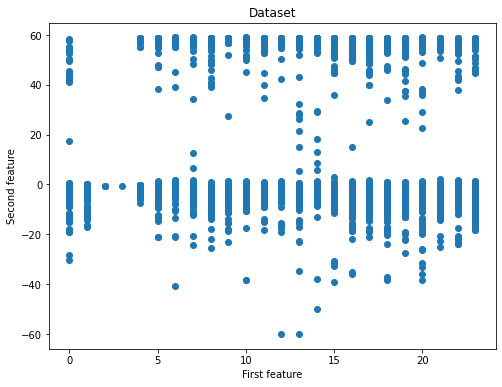

In [118]:
fig = plt.figure(figsize=(8,6))
plt.scatter(X.iloc[:,3], y)
plt.title("Dataset")
plt.xlabel("First feature")
plt.ylabel("Second feature")
plt.show()

In [119]:
# Split the data into a training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y)

print(f'Shape X_train: {X_train.shape}')
print(f'Shape y_train: {y_train.shape}')
print(f'Shape X_test: {X_test.shape}')
print(f'Shape y_test: {y_test.shape}')

Shape X_train: (37885, 4)
Shape y_train: (37885, 1)
Shape X_test: (12629, 4)
Shape y_test: (12629, 1)


In [120]:
class LinearRegression:
    
    def __init__(self):
        pass

    def train_gradient_descent(self, X, y, learning_rate=0.01, n_iters=100):
        """
        Trains a linear regression model using gradient descent
        """
        # Step 0: Initialize the parameters
        n_samples, n_features = X.shape
        self.weights = np.zeros(shape=(n_features,1))
        self.bias = 0
        costs = []

        for i in range(n_iters):
            # Step 1: Compute a linear combination of the input features and weights
            y_predict = np.dot(X, self.weights) + self.bias

            # Step 2: Compute cost over training set
            cost = (1 / n_samples) * np.sum((y_predict - y)**2)
            costs.append(cost)

            if i % 100 == 0:
                print(f"Cost at iteration {i}: {cost}")

            # Step 3: Compute the gradients
            dJ_dw = (2 / n_samples) * np.dot(X.T, (y_predict - y))
            dJ_db = (2 / n_samples) * np.sum((y_predict - y)) 
            
            # Step 4: Update the parameters
            self.weights = self.weights - learning_rate * dJ_dw
            self.bias = self.bias - learning_rate * dJ_db

        return self.weights, self.bias, costs

    def train_normal_equation(self, X, y):
        """
        Trains a linear regression model using the normal equation
        """
        self.weights = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y)
        self.bias = 0
        
        return self.weights, self.bias

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

In [121]:
regressor = LinearRegression()
w_trained, b_trained, costs = regressor.train_gradient_descent(X_train, y_train, learning_rate=0.005, n_iters=600)

fig = plt.figure(figsize=(8,6))
plt.plot(np.arange(600), costs)
plt.title("Development of cost during training")
plt.xlabel("Number of iterations")
plt.ylabel("Cost")
plt.show()

TypeError: ignored